In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Resizing, Rescaling
from sklearn.cluster import KMeans

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil

import imageio

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [22]:
# Extract data
X = np.load('Xtrain_Classification_Part2.npy')
y = np.load('Ytrain_Classification_Part2.npy')

X_train, X_validate, train_labels, test_labels = train_test_split(X,y)


In [23]:
class_names = ['caucasian', 'african', 'asian', 'indian']

# Reshape to 50x50 pixel images
pixels = 50
train_images = []
test_images = []

for image in X_train:
    train_images.append(image.reshape(pixels, pixels))

for image in X_validate:
    test_images.append(image.reshape(pixels, pixels))

train_images = np.array(train_images)
test_images = np.array(test_images)

In [24]:
# Normalizing
train_images = train_images / 255.0
test_images = test_images / 255.0

X_train = X_train / 255.0
X_validate = X_validate / 255.0

In [25]:
caucasian_count = 0
african_count = 0
asian_count = 0
indian_count = 0

caucasian_train = []
african_train = []
asian_train = []
indian_train = []

for index, label in enumerate(train_labels):
    if label == 0:
        caucasian_count += 1
        caucasian_train.append(train_images[index])
    elif label == 1:
        african_count += 1
        african_train.append(train_images[index])
    elif label == 2:
        asian_count += 1
        asian_train.append(train_images[index])
    elif label == 3:
        indian_count += 1
        indian_train.append(train_images[index])

In [26]:
# Augment african data by adding mirrored images

african_train = np.array(african_train)
african_augmented = []

african_flipped = african_train[:,:,::-1]

for index, image in enumerate(african_flipped):
    african_augmented.append(african_train[index])
    african_augmented.append(image)

african_augmented = np.array(african_augmented)


In [27]:
# Augment asian data by adding mirrored images

asian_train = np.array(asian_train)
asian_augmented = []

asian_flipped = asian_train[:,:,::-1]

for index, image in enumerate(asian_flipped):
    asian_augmented.append(asian_train[index])
    asian_augmented.append(image)

asian_augmented = np.array(asian_augmented)

In [28]:
# Augment indian data by adding mirrored images

indian_train = np.array(indian_train)
indian_augmented = []

indian_flipped = indian_train[:,:,::-1]

for index, image in enumerate(indian_flipped):
    indian_augmented.append(indian_train[index])
    indian_augmented.append(image)

indian_augmented = np.array(indian_augmented)

In [29]:
# Update training set
#pixels = 50

new_train_images = []
new_train_labels = []

count_african = 0
count_asian = 0
count_indian = 0

for index, label in enumerate(train_labels):
    if label == 0:
        new_train_images.append(train_images[index].reshape(pixels,pixels))
        new_train_labels.append(label)
    elif label == 1:
        new_train_images.append(african_augmented[count_african].reshape(pixels,pixels))
        new_train_labels.append(label)
        new_train_images.append(african_augmented[count_african + african_count].reshape(pixels,pixels))
        new_train_labels.append(label)
        count_african += 1
    elif label == 2:
        new_train_images.append(asian_augmented[count_asian].reshape(pixels,pixels))
        new_train_labels.append(label)
        new_train_images.append(asian_augmented[count_asian + asian_count].reshape(pixels,pixels))
        new_train_labels.append(label)
        count_asian += 1
    elif label == 3:
        new_train_images.append(indian_augmented[count_indian].reshape(pixels,pixels))
        new_train_labels.append(label)
        new_train_images.append(indian_augmented[count_indian + indian_count].reshape(pixels,pixels))
        new_train_labels.append(label)
        count_indian += 1


print(new_train_images[0].shape)

new_train_images = np.array(new_train_images)
print(new_train_images.shape)


(50, 50)
(7673, 50, 50)


In [30]:
# Building CNN Model
model = keras.Sequential()
#model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation="softmax"))

In [31]:
model.compile(  optimizer='adam',
                loss = 'sparse_categorical_crossentropy', #'binary_crossentropy',
                metrics = ['accuracy'])

In [32]:
# Train model
#train_images = np.reshape(train_images, (len(train_images), 50, 50, 1))
test_images = np.reshape(test_images, (len(test_images),50, 50, 1))
test_images = np.asarray(test_images)

new_train_images = np.reshape(new_train_images, (len(new_train_images), 50, 50, 1))
new_train_images = np.asarray(new_train_images)

new_train_labels = np.asarray(new_train_labels)
#print(type(new_train_images))
#print(type(train_images))
history = model.fit(new_train_images, new_train_labels, validation_data = (test_images, test_labels), epochs = 10)

Epoch 1/10
240/240 [==============================] - 39s 164ms/step - loss: 1.0515 - accuracy: 0.5467 - val_loss: 0.8485 - val_accuracy: 0.6363
Epoch 2/10
240/240 [==============================] - 35s 145ms/step - loss: 0.7380 - accuracy: 0.7167 - val_loss: 0.6928 - val_accuracy: 0.7514
Epoch 3/10
240/240 [==============================] - 36s 149ms/step - loss: 0.6386 - accuracy: 0.7625 - val_loss: 0.5829 - val_accuracy: 0.7921
Epoch 4/10
240/240 [==============================] - 35s 147ms/step - loss: 0.5479 - accuracy: 0.8001 - val_loss: 0.5141 - val_accuracy: 0.8122
Epoch 5/10
240/240 [==============================] - 35s 145ms/step - loss: 0.4979 - accuracy: 0.8169 - val_loss: 0.5601 - val_accuracy: 0.7850
Epoch 6/10
240/240 [==============================] - 35s 147ms/step - loss: 0.4601 - accuracy: 0.8331 - val_loss: 0.5338 - val_accuracy: 0.8094
Epoch 7/10
240/240 [==============================] - 35s 146ms/step - loss: 0.4144 - accuracy: 0.8457 - val_loss: 0.4982 - val_ac

In [33]:
new_train_caucasian_count = 0
new_train_african_count = 0
new_train_asian_count = 0
new_train_indian_count = 0

for index, label in enumerate(new_train_labels):
    if label == 0:
        new_train_caucasian_count += 1
    elif label == 1:
        new_train_african_count += 1
    elif label == 2:
        new_train_asian_count += 1
    elif label == 3:
        new_train_indian_count += 1

print(new_train_caucasian_count)
print(new_train_african_count)
print(new_train_asian_count)
print(new_train_indian_count)

3375
494
2012
1792


In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 50, 50, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)       

In [35]:
# Accuracy
test_images = test_images.reshape(-1, 50, 50, 1)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

58/58 [==============================] - 2s 32ms/step - loss: 0.4811 - accuracy: 0.8398
Test accuracy: 0.839847981929779


In [36]:
predictions = model.predict(test_images) #test_images
predictions

array([[9.9785501e-01, 7.8264292e-04, 1.5360728e-04, 1.2088326e-03],
       [7.9891101e-02, 2.0281336e-01, 6.9234982e-02, 6.4806056e-01],
       [2.8838899e-06, 1.0332368e-12, 9.9999714e-01, 5.2484631e-11],
       ...,
       [2.5875455e-01, 3.6992512e-03, 7.3352695e-01, 4.0193344e-03],
       [9.9302691e-01, 4.4968962e-03, 1.0070485e-03, 1.4691291e-03],
       [1.0595447e-01, 2.4596106e-02, 6.1924302e-04, 8.6883014e-01]],
      dtype=float32)

In [37]:
# Turn predictions into labels
y_predicted = []

for i in predictions:
    y_predicted.append(np.argmax(i))

y_predicted = np.array(y_predicted)
print(y_predicted)

[0 3 2 ... 2 0 3]


BACC = 78.7692831875381


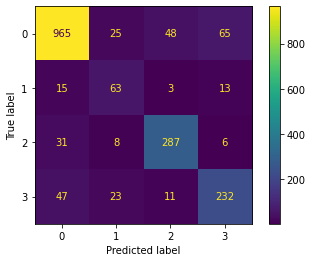

In [38]:
bacc = balanced_accuracy_score(test_labels, y_predicted)

cm = confusion_matrix(test_labels, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
print(f"BACC = {bacc * 100}")

In [39]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                            100*np.max(predictions_array),
                                            class_names[true_label]),
                                            color = color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color = '#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

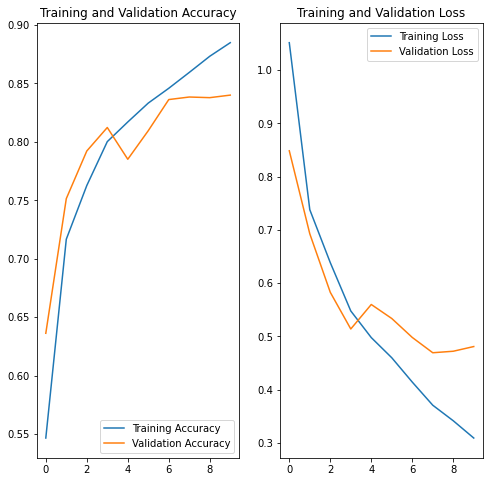

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

